# Barycenter DTW

In [133]:
import pandas as pd
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.interpolate import interp1d
import numpy as np
import import_ipynb
import matplotlib.pyplot as plt


In [134]:
from ExtractShapelets import vector_accer, find_represt_shapelet

### Restore representative shapelet

In [135]:
%store -r z_jump_rs
%store -r z_walk_rs
%store -r z_skip_rs

%store -r z_jump_ordered_candidates
%store -r z_walk_ordered_candidates
%store -r z_skip_ordered_candidates

%store -r z_jump
%store -r z_walk
%store -r z_skip

In [136]:
%store -r g_jump_rs
%store -r g_walk_rs
%store -r g_skip_rs

%store -r g_jump_ordered_candidates
%store -r g_walk_ordered_candidates
%store -r g_skip_ordered_candidates

%store -r g_jump
%store -r g_walk
%store -r g_skip

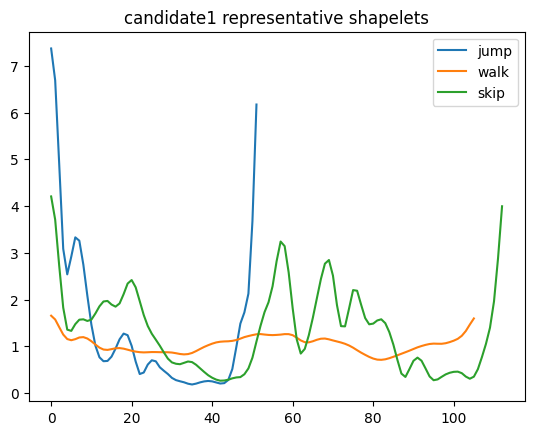

In [137]:
plt.plot(z_jump_rs, label='jump')
plt.plot(z_walk_rs, label='walk')
plt.plot(z_skip_rs, label='skip')
plt.title('candidate1 representative shapelets')
plt.legend()
plt.show()


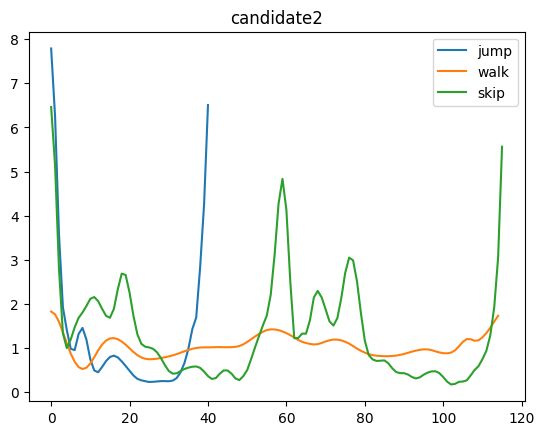

In [138]:
plt.plot(g_jump_rs, label='jump')
plt.plot(g_walk_rs, label='walk')
plt.plot(g_skip_rs, label='skip')
plt.title('candidate2')
plt.legend()
plt.show()

In [139]:
# Function to resample a sequence to a target length
def resample_sequence(sequence, target_length):
    x = np.linspace(0, 1, len(sequence))
    f = interp1d(x, sequence, kind='linear', fill_value='extrapolate')
    x_new = np.linspace(0, 1, target_length)
    return f(x_new)

# Function to calculate the barycenter sequence using DTW
def barycenter_dtw(df1, df2):
    # Resample the longer sequence to the length of the shorter one
    max_length = max(len(df1), len(df2))
    df1_resampled = pd.DataFrame({col: resample_sequence(df1[col].values, max_length) for col in df1.columns})
    df2_resampled = pd.DataFrame({col: resample_sequence(df2[col].values, max_length) for col in df2.columns})

    # _, path = fastdtw(df1_resampled.values, df2_resampled.values, dist=euclidean)

    # Use the alignment path to calculate the barycenter sequence
    barycenter_seq = df1_resampled.values + df2_resampled.values
    barycenter_seq /= 2

    # Convert the barycenter sequence back to DataFrame
    barycenter_df = pd.DataFrame(barycenter_seq, columns=df1.columns)

    return barycenter_df

def visual_shapelet(jump, walk, skip, title):
    """
    This is a method to visualiz the barycenter dtw shapelet and skip representative shapelet 

    :jump: is jump representative shapelet
    :walk: is walk representative shapelet
    :skip: is skip representative shapelet
    """
    df1 = pd.DataFrame(walk)
    # double the jump shapelets, because one cycle of walk and skip is two cycle of jump
    df2 = pd.concat([pd.DataFrame(jump), pd.DataFrame(jump)], ignore_index=True)
    barycenter_df = barycenter_dtw(df1, df2)
    plt.plot(barycenter_df, label='walk and jump barycenter dtw')
    plt.plot(skip, label='skip' )
    plt.legend()
    plt.title(title)
    plt.show()
    # Distance Comparison
    distance, path = fastdtw(barycenter_df, pd.DataFrame(skip), dist=euclidean)
    print("Distance of walk_jump_barycenter with skip is:", distance)
    distance, path = fastdtw(pd.DataFrame(walk), pd.DataFrame(skip), dist=euclidean)
    print("Distance of walk with skip is:", distance)
    distance, path = fastdtw(pd.DataFrame(jump), pd.DataFrame(skip), dist=euclidean)
    print("Distance of jump with skip is:", distance)

## Combine best activity shapelets

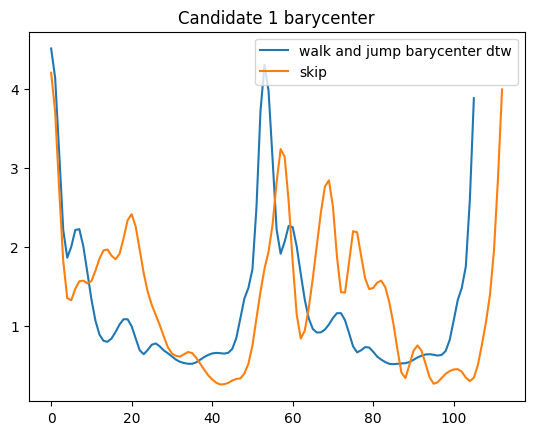

Distance of walk_jump_barycenter with skip is: 27.25515360900614
Distance of walk with skip is: 56.269580957532355
Distance of jump with skip is: 48.98214638161351


In [140]:
visual_shapelet(z_jump_rs, z_walk_rs, z_skip_rs, 'Candidate 1 barycenter')

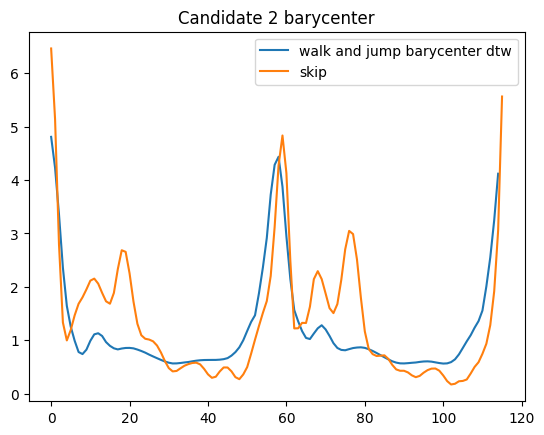

Distance of walk_jump_barycenter with skip is: 36.81881732919427
Distance of walk with skip is: 70.49681636224669
Distance of jump with skip is: 58.543492210017774


In [141]:
visual_shapelet(g_jump_rs, g_walk_rs, g_skip_rs, 'Candidate 2 barycenter')

## Combine top 5 best candidate shapelets

In [142]:
# Following 3 methods are from Grant tsshapelet package
def interpolate(array, length):
    array_length = len(array)
    return interp1d(np.arange(0, array_length), array)(np.linspace(0.0, array_length-1, length))

def average_barycenter(X):
    return np.mean(X, axis = 0)

def interpolated_average(X):
    length = np.mean(np.array(list(map(len, X))), dtype = int)
    interpolated_candidates = [interpolate(arr, length) for arr in X]
    return average_barycenter(interpolated_candidates)

In [143]:
def candidates_pick_comparison(z_jump_ordered_candidates, z_walk_ordered_candidates, z_skip_ordered_candidates):
    min_candidates = min(len(z_jump_ordered_candidates), len(z_walk_ordered_candidates), len(z_skip_ordered_candidates))
    for num in range(2, min_candidates, 2):
        bary_jump = interpolated_average(z_jump_ordered_candidates[: num])
        bary_walk = interpolated_average(z_walk_ordered_candidates[: num])
        bary_skip = interpolated_average(z_skip_ordered_candidates[: num])
        visual_shapelet(bary_jump, bary_walk, bary_skip, ' Candidate 1 Top ' + str(num) + ' barycenter')

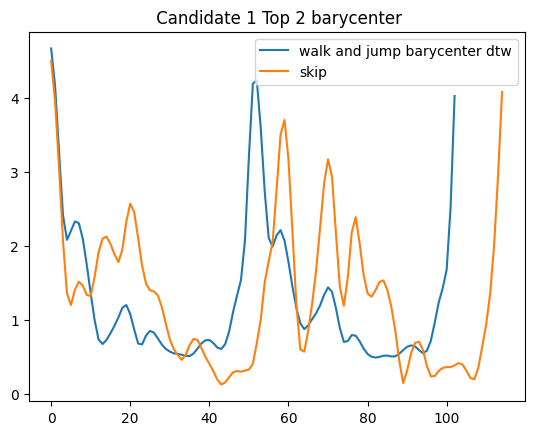

Distance of walk_jump_barycenter with skip is: 36.18226188918722
Distance of walk with skip is: 57.40160976389825
Distance of jump with skip is: 47.83534856692896


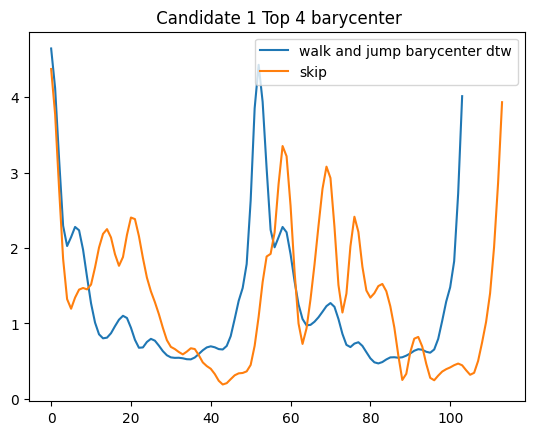

Distance of walk_jump_barycenter with skip is: 32.17444281418745
Distance of walk with skip is: 58.38633514178846
Distance of jump with skip is: 49.47643283330858


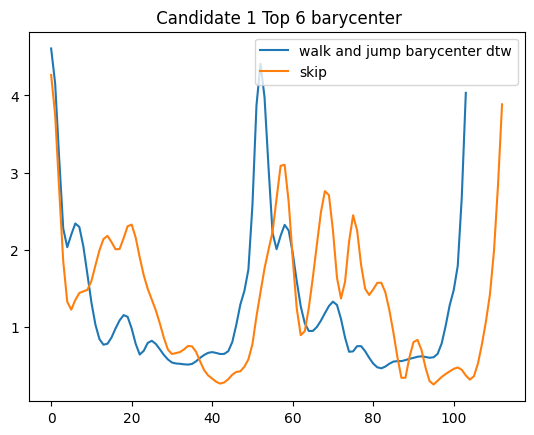

Distance of walk_jump_barycenter with skip is: 29.310779624447484
Distance of walk with skip is: 53.5771381805644
Distance of jump with skip is: 45.37136625958607


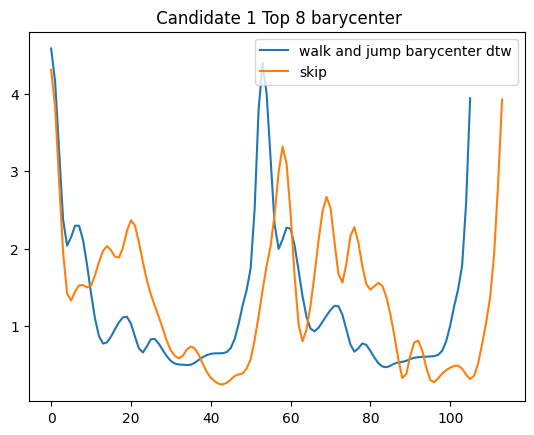

Distance of walk_jump_barycenter with skip is: 27.273433150423813
Distance of walk with skip is: 55.03546601214491
Distance of jump with skip is: 46.556233473875515


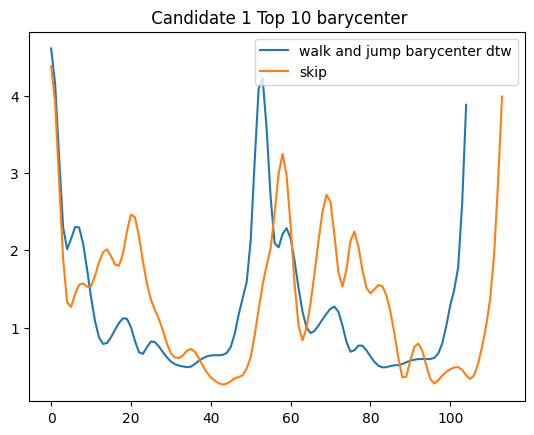

Distance of walk_jump_barycenter with skip is: 28.769010630046505
Distance of walk with skip is: 55.74266447541097
Distance of jump with skip is: 46.5426164129408


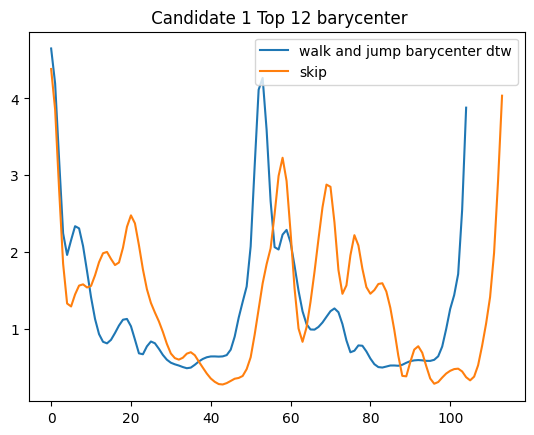

Distance of walk_jump_barycenter with skip is: 30.857328117009438
Distance of walk with skip is: 55.663359720154226
Distance of jump with skip is: 48.89388095335648


In [144]:
candidates_pick_comparison(z_jump_ordered_candidates, z_walk_ordered_candidates, z_skip_ordered_candidates)

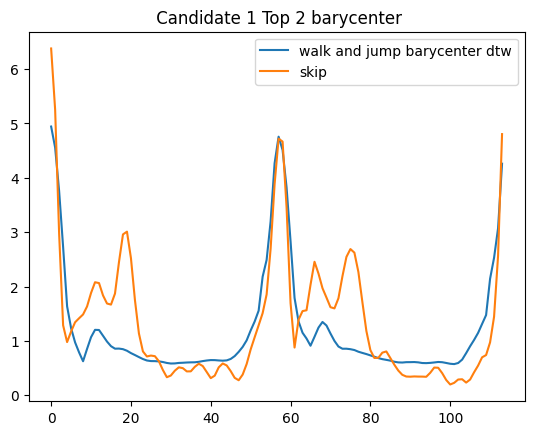

Distance of walk_jump_barycenter with skip is: 36.39446612656843
Distance of walk with skip is: 65.77360814541092
Distance of jump with skip is: 61.57258808414582


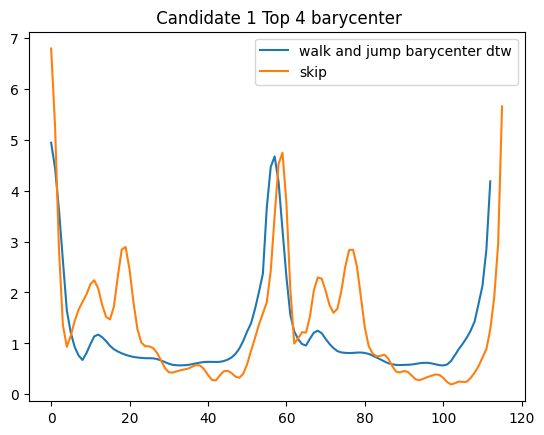

Distance of walk_jump_barycenter with skip is: 38.91216971380475
Distance of walk with skip is: 73.52481706713074
Distance of jump with skip is: 57.480285454966264


In [145]:
candidates_pick_comparison(g_jump_ordered_candidates, g_walk_ordered_candidates, g_skip_ordered_candidates)